<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%22%D0%93%D0%90_%D0%B4%D0%BB%D1%8F_%D0%9D%D0%A1_Light_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание и загрузка библиотек

Взяв за основу ГА из занятия, нарастите сложность сверточной сети, которая генерируется.

Сделайте возможность бота создать любую последовательность слоев. Количество слоев должно задаваться ботом.
Можно жёстко настроить появление Flatten и полносвязные слои только в конце.
Полносвязные слои ГА также может генерить в произвольном количестве (количество слоев содержиться в боте).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Reshape, BatchNormalization, Input, GlobalMaxPool1D, UpSampling1D
from tensorflow.keras.layers import Conv2DTranspose, Lambda, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation
from tensorflow.keras.losses import MAE
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from PIL import Image
from google.colab import files

import time
import random as random
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_data = pd.read_csv('/content/drive/MyDrive/БАЗЫ/traff.csv', header=None)

In [ ]:
base_data

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"
...,...,...
1090,12/27/2019,"29,801.00"
1091,12/28/2019,"34,913.00"
1092,12/29/2019,"37,665.00"
1093,12/30/2019,"32,643.00"


In [ ]:
data = base_data.iloc[:, 1] # убираем столбец времени
d = data # для простоты
print(len(d))
print(len(d.iloc[0])) # длина одной строки вместе с запятой и точкой
print(d.iloc[0])

1095
9
22,226.00


In [ ]:
data

0       22,226.00
1       29,593.00
2       31,726.00
3       32,684.00
4       31,820.00
          ...    
1090    29,801.00
1091    34,913.00
1092    37,665.00
1093    32,643.00
1094    28,212.00
Name: 1, Length: 1095, dtype: object

In [ ]:
data = np.array(data)
for i in range(len(data)):
  data[i] = float(data[i].replace(',', ''))# вместо запятой, ставим пусто

In [ ]:
data # смотрим чего получилось. Должны придти к одномерному массиву вещественных чисел

array([22226.0, 29593.0, 31726.0, ..., 37665.0, 32643.0, 28212.0],
      dtype=object)

# Загрузка  данных

временные ряды

In [ ]:
xlen = 60 # берём кусок для анализа
valLen = 300 # кол-во записей для проверки
trainLen = data.shape[0] - valLen #размер тренировочный
Train, Test = np.reshape(data[:trainLen], (-1, 1)), np.reshape(data[trainLen + xlen + 2:], (-1, 1)) # тренировочная и тестовая


print(Train.shape)
print(Test.shape)

(795, 1)
(238, 1)


In [ ]:
Scaler = MinMaxScaler()#  метод маштабирования
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)


In [ ]:
trainDataGen = TimeseriesGenerator(Train, Train, length=xlen, sampling_rate=1, batch_size=20)# генератор для обучения.
testDataGen = TimeseriesGenerator(Test, Test, length=xlen, batch_size=20)


отображение результатов:

In [ ]:
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if showGraf: #Если нужно показать график
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData: #Если нужно вернуть массивы автокорреляции
    return corr, own_corr

In [ ]:
def getPred(currModel, xVal, yVal, yScaler): # функция прогнозирования сети. currModel- агрумент сети
  predVal = yScaler.inverse_transform(currModel.predict(xVal)) # предсказание ответа в сети и сразу перевод в исходное значение
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled): # start-начало графика, step-длина, и ответы  в прошлой функции
  plt.plot(predVal[start:start+step, channel], label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')

def correlate(a, b): # корреляция двух одномерных векторов
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()

  val = 0
  if ((sa>0)and(sb>0)):
    val = (mab - ma*mb)/(sa*sb)
  return val

#def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf=True, returnData=False):
  #   channels-по каким каналам отображаем коррелляцию
  #   corrsteps- количество шагов смещать сигнал назад для расчёта корреляции
  #   showGraf-показывать график или нет
  #   returnData-возвращаем массивы автокорреляции или нет
  for ch in channels:
    corr = [] #пустой лист, корреляция при смещении на i-шагов обратно
    yLen = yValUnscaled.shape[0]
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i, ch], predVal[i:, ch]))
      # i- увеличиваем шаг сигнала назад для проверки автокорреляции
      # predVal[i:. ch]- сравниваем сигнал i назад (i:)
      # yValUnscaled[:yLen-i, ch]- сравниваем сигнал с верным ответом без смещения :yLen-i
    
    own_corr = [] # делаем ещё такой же цикл. это было в лекции по временным рядам
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i, ch], predVal[i:, ch]))
    
    if showGraf: # не забывать это в цикле, и показывает только для данного шага
      plt.plot(corr, label='предсказание на ' + str(ch+1) + 'шаг')
      plt.plot(own_corr, label='Эталон')
  
  #if showGraf: # график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()
  
  #if returnData: # если нужно вернуть массив автокорреляции
    return corr, own_corr
    

#  Индексы архитектуры

**генерация проверочной выборки**

In [ ]:
DataGen = TimeseriesGenerator(Test, Test, length=xlen, batch_size=len(Test)) 
xVal = []
yVal = [] 
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])
xVal = np.array(xVal)
yVal = np.array(yVal)

**Назначение индексов архитектуры:**

**Входной слой**

*   0 - делаем нормализацию. да/нет

*   1 - размер первого свёрточного слоя

*   2 - ядро первого свёрточного слоя
*   3 - функция активации первого слоя


*   4 - MaxPooling0. да/нет


*   5 - размер MaxPooling0


---
**Первый скрытый слой**


*   6 - второй свёрточный слой. да/нет
*   7 - размер второго свёрточного слоя

*   8 - ядро второго свёрточного слоя
*   9 - MaxPooling1. да/нет

*   10 - размер MaxPooling1
*   11 - фунция активации


---
**Второй скрытый слой**


*   12 - третий свёрточный слой. да/нет
*   13 - размер третьего свёрточного слоя

*   14 - ядро третьего свёрточного слоя
*   15 - MaxPooling2. да/нет

*   16 - размер MaxPooling2
*   17 - функция активации
---
**слой Flatten**


*   18 - cлой Flatten
**первый полносвязный слой**

*   19 - полносвязный слой dense0 . да/нет
*   20 - размер полносвязного слоя denseSize0 
*   21 - функция активации activation5
**второй полносвязный слой** 

*   22 - полносвязный слой dense1.  да/нет
*   23 - размер полносвязного слоя denseSize1
*   24 - функция активации activation6
**третий полносвязный слой**

*   25 - полносвязный слой dense2. да/нет
*   26 - размер полносвязного слоя denseSize2
*   27 - функция активации activation7 

*   28 - функция активации выходного слоя
*    - 

---
**Предпоследний скрытый слой** 

*    29 - нормализация. да/нет


# Функция Модели

In [ ]:
def createConvNet(net): # по порядочку забиваем составляющие модели по индексам

  model = Sequential()             # Создаем модель Sequential
  
  makeFirstNormalization = net[0]  # нормализация в начале. да/нет
  firstConvSize = 2 ** net[1]      # Размер первого вёрточного слоя
  firstConvKernel = net[2]         # Ядро первого свёрточного слоя
  activation0 = net[3]             # Функция активации входного слоя
  makeMaxPooling0 = net[4]         # maxpooling для нулевого слоя. да/нет
  maxPoolingSize0 = net[5]         # Размер MaxPooling

  makeSecondConv = net[6]          # Делаем ли второй свёрточный слой
  secondConvSize = 2 ** net[7]     # Размер второго свёрточного слоя
  secondConvKernel = net[8]        # Ядро второго свёрточного слоя
  makeMaxPooling1 = net[9]         # Делаем ли MaxPooling
  maxPoolingSize1 = net[10]        # Размер MaxPooling
  activation1 = net[11]            # Функция активации

  makeThirdConv = net[12]          # Делаем ли второй свёрточный слой
  thirdConvSize = 2 ** net[13]     # Размер второго свёрточного слоя
  thirdConvKernel = net[14]        # Ядро второго свёрточного слоя
  makeMaxPooling2 = net[15]        # Делаем ли MaxPooling. да/нет
  maxPoolingSize2 = net[16]        # Размер MaxPooling
  activation2 = net[17]            # Функция активации

  flatten0 = net[18]                  # Функция спрямления

  dense0 = net[19]                    # Полносвязный слой да/нет
  denseSize0 =2** net [20]                # Размер полносвязного слоя 
  activation5 = net[21]               # Функция активации 

  dense1 = net[22]                    # Полносвязный слой да/нет
  denseSize1 = 2**net[23]                # Размер полносвязного слоя 
  activation6 = net[24]               # Функция активации

  dense2 = net[25]                    # Полносвязный слой да/нет
  denseSize2 = 2**net[26]                # Размер полносвязного слоя 
  activation7 = net[27]                # Функция активации activation7
 
  #activation3 = net[]            # Функция активации для 
  activation4 = net[28]            # Функция активации для последнего слоя
  makeSecondNormalization = net[29] # Делаем ли финальную нормализацию
  
  #denseSize = 2 ** net[]          # Размер полносвязного слоя

  activation_list = ['linear', 'relu', 'tanh', 'softmax', 'sigmoid'] # лист активационных функций

  if (makeFirstNormalization): # если добавляется слой нормализации, указать размер на входе
    model.add(BatchNormalization(input_shape=(xlen, 1)))
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same'))
  else: # если нет, то просто добавляется свёртка, но с указанием обязательно размера входа
    model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xlen, 1), activation=activation_list[activation0], padding='same'))
  if makeMaxPooling0:
    model.add(MaxPooling1D(maxPoolingSize0)) # добавляем, если добавляем макспуллинг
  
  # второй свёрточный слой, если делаем
  if (makeSecondConv):
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same'))
    if (makeMaxPooling1): # если решили добавить макспулиннг
      model.add(MaxPooling1D(pool_size=maxPoolingSize1))
  
  # третий свёрточноый слой, если делаем
  if (makeThirdConv):
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same'))
    if (makeMaxPooling2):
      model.add(MaxPooling1D(pool_size=maxPoolingSize2))

  # Flatten жёстко привязан к модели
  if (flatten0):
    model.add(Flatten())
# ПОПРОБУЮ, НЕ ФАКТ
  for i in range(1, 4):
  # полносвязный слой 1, если делаем
    if (dense0):
      model.add(Dense(denseSize0, activation=activation_list[activation5]))
  
  # полносвязный слой 2, если делаем
    if (dense1):
      model.add(Dense(denseSize1, activation=activation_list[activation6]))
  
  # полносвязный слой 3, если делаем
    if (dense2):
      model.add(Dense(denseSize2, activation=activation_list[activation7]))
  



  
  # финальная нормализация
  if (makeSecondNormalization):
    model.add(BatchNormalization())

  # вытягиваем свёртку
  #model.add(Flatten())

  # полносвязный слой Dense
  #model.add(Dense(denseSize, activation= activation_list[activation3]))

  # финальный выходной слой с одним нейроном и функцией сигмоид
  model.add(Dense(1, activation=activation_list[activation4]))
  return model


теперь набираем диапазоны параметров для каждого будущего индекса(29 индекса) из случайных чисел

In [ ]:
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) #Делаем или нет нормализацию
  net.append(random.randint(3,7)) #Первый свёрточный слой от 8 до 128 нейронов
  net.append(random.randint(3,8)) #Ядро первого свёрточного слоя от 3 до 8
  net.append(random.randint(0,4)) # Функция активации первого слоя
  net.append(random.randint(0,1)) #Делаем ли MaxPooling
  net.append(random.randint(2,3)) #Размер MaxPooling

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,8)) # Второй свёрточный слой от 8 до 256 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,3)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,7)) # Второй свёрточный слой от 8 до 128 нейронов
  net.append(random.randint(3,8)) # Ядро второго свёрточного слоя от 3 до 8
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,3)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randrange(1,2)) # Flatten, будет всегда давать единицу
  net.append(random.randint(0,1)) # dense0, будет ли полносвязный слой
  net.append(random.randint(4, 10)) # количество нейронов
  net.append(random.randint(0, 4)) # активация первого слоя индекс 21
  # второй полносвязный
  net.append(random.randint(0, 1)) # dense1.  делаем или нет
  net.append(random.randint(4, 8)) # количество нейронов
  net.append(random.randint(0, 4)) # активация второго слоя индекс 24
  # третий полносвязный
  net.append(random.randint(0, 1)) # делаем или нет
  net.append(random.randint(4, 10)) # количество нейронов
  net.append(random.randint(0, 4)) # активация третьего слоя индекс 27

  net.append(random.randint(0, 1)) # активация для выходного слоя индекс 28
  net.append(random.randint(0, 4)) # финальная нормализация

  #net.append(random.randint(0,1)) # Делаем ли финальную нормализацию слой
  #net.append(random.randint(3,8)) # Размер полносвязного слоя от 8 до 256
  
  return net

вычисление результата работы сети:

In [ ]:
from tensorflow.python.ops.gen_sparse_ops import AddManySparseToTensorsMap
from tensorflow.keras import optimizers
def evaluateNet(net, ep, verb):
  val = 0
  time.time() # Засекаем время
  model = createConvNet(net) # создаём модель из функции выше
  model.compile(optimizer=Adam(lr=1e-4), loss='mse')
  history = model.fit_generator(trainDataGen, epochs=5, verbose=verb, validation_data=testDataGen)
  val = history.history['val_loss'][-1] # минус один-последнее значение
  return val, model

# Боты

In [ ]:
n = 30 # число ботов
nsurv = 10 # выжившие
nnew = n - nsurv # cколько добивать
l = 30 # размер бота, равный числу индексов архитектуры модели. см. выжившие
epohs = 10 
mut = 0.1 # мутация
popul = [] #  создаём пустой массив популяций
val = [] # одномерный массив ботов из популяций

# cоздание случайных ботов
for i in range(n):
  popul.append(createRandomNet()) # добавляется 20 различных ботов из случайных значений функции createRandomNet

for it in range(epohs): # Пробегаем по всем эпохам
  val = []  # Обнуляем значения бота
  curr_time = time.time() # начало отсчёта времени
  for i in range(n):  # Пробегаем в цикле по всем ботам 
    bot = popul[i]   # Берем очередного бота
    f, model_sum = evaluateNet(bot, 3, 0) # Вычисляем точность текущего бота. Функция выше
    val.append(f)  #  значение в список val
  
  sval = sorted(val, reverse=0)         # Сортируем val по возрастанию reverse=0
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) # 5 лучших
  
  newpopul = []  #  пустой список под новую популяцию
  for i in range(nsurv): # Пробегаем по всем выжившим ботам
    index = val.index(sval[i]) # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index]) # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew): # Проходимся в цикле nnew-раз. здесь 10 раз 
    indexp1 = random.randrange(0,nsurv) # Случайный индекс первого родителя в диапазоне от 0 до nsurv
    indexp2 = random.randrange(0,nsurv) # Случайный индекс первого родителя в диапазоне от 0 до nsurv
    botp1 = newpopul[indexp1]  # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]   # Получаем второго бота-родителя по indexp2    
    newbot = []   # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):  # Пробегаем по всей длине размерности (22)      
      x = 0      
      pindex = random.random()  # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]

      # С вероятностью mut устанавливаем значение бота из net4Mut. Можно впихнуть это и в один цикл, через elif
      if (random.random() < mut):
        x = net4Mut[j]
      newbot.append(x) #  и выходим из цикла
    newpopul.append(newbot) # добиваем остатки к лучшим. и выходим из цикла "for it in range(epohs)" 
  popul = newpopul # из пустого списка,  список стал гиперпараметром

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


0 54.071070432662964   [0.011083305813372135, 0.01280076615512371, 0.042271506041288376, 0.06120356172323227, 0.06908769905567169] [[1, 7, 4, 1, 0, 3, 1, 6, 5, 1, 2, 2, 1, 4, 8, 1, 2, 3, 1, 0, 8, 3, 1, 4, 4, 1, 7, 0, 1, 4], [0, 5, 6, 4, 0, 3, 0, 3, 7, 0, 2, 1, 1, 7, 6, 0, 2, 1, 1, 1, 8, 4, 0, 6, 1, 0, 10, 1, 0, 3], [0, 5, 6, 2, 0, 2, 0, 5, 3, 0, 3, 2, 1, 5, 8, 0, 3, 3, 1, 1, 9, 2, 1, 5, 3, 0, 10, 0, 1, 4], [0, 5, 7, 1, 1, 2, 0, 4, 3, 1, 2, 4, 1, 3, 6, 0, 3, 2, 1, 0, 7, 3, 1, 5, 1, 0, 6, 4, 1, 2], [0, 4, 8, 3, 0, 3, 0, 8, 6, 1, 2, 1, 1, 6, 3, 1, 2, 3, 1, 0, 9, 1, 0, 4, 0, 0, 4, 4, 1, 0]]
1 50.32929444313049   [0.015179797075688839, 0.02457636408507824, 0.025393608957529068, 0.0458584688603878, 0.05413768067955971] [[0, 7, 6, 0, 1, 2, 1, 4, 5, 1, 2, 0, 1, 4, 3, 0, 3, 1, 1, 0, 4, 4, 0, 8, 0, 1, 6, 2, 0, 0], [0, 3, 6, 4, 1, 3, 0, 8, 6, 1, 3, 0, 1, 6, 6, 0, 3, 0, 1, 1, 10, 2, 0, 5, 0, 0, 4, 0, 0, 0], [1, 5, 5, 2, 1, 2, 0, 5, 3, 0, 2, 4, 0, 7, 6, 0, 2, 4, 1, 0, 7, 1, 0, 8, 1, 0, 10, 2, 0, 3]

In [ ]:
model = createConvNet(popul[0])
model.summary()

Model: "sequential_601"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1205 (Conv1D)        (None, 60, 32)            256       
                                                                 
 conv1d_1206 (Conv1D)        (None, 60, 256)           49408     
                                                                 
 max_pooling1d_690 (MaxPooli  (None, 30, 256)          0         
 ng1D)                                                           
                                                                 
 flatten_601 (Flatten)       (None, 7680)              0         
                                                                 
 dense_2434 (Dense)          (None, 128)               983168    
                                                                 
 dense_2435 (Dense)          (None, 128)               16512     
                                                    

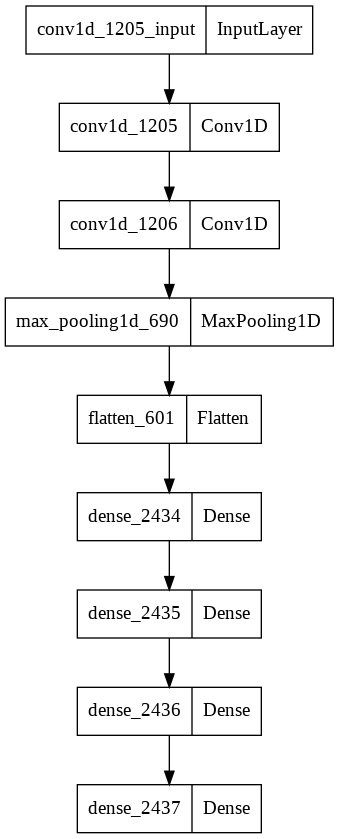

In [ ]:
plot_model(model)

странно, но сработал

In [ ]:
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

In [ ]:
history = model.fit_generator(trainDataGen, epochs=100, validation_data=testDataGen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/100
37/37 [==============================] - 1s 7ms/step - loss: 0.0307 - val_loss: 0.0290
Epoch 2/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0236
Epoch 3/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0171 - val_loss: 0.0060
Epoch 4/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 5/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 6/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0056
Epoch 7/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 8/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 9/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 10/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 11/

# Проверки

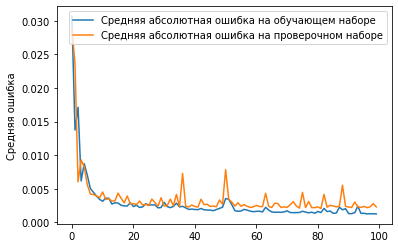

In [ ]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
currModel = model # модель которую обучали
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) # ф-ция прогноз. см на самом верху getPred()

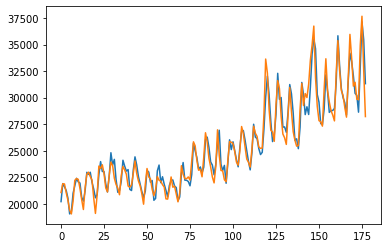

In [ ]:
showPredict(0, 400, 0, predVal, yValUnscaled)# напоминалка showPredict(start, step, channel, predVal, yValUnscaled) 

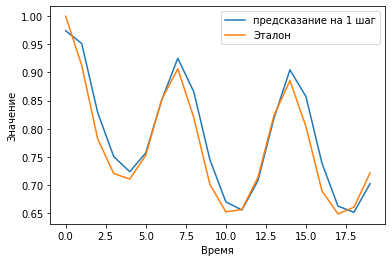

In [ ]:
autoCorr([0], 20, predVal, yValUnscaled)

**Вывод:** меня изматал синтаксис. А по заданию, модель запускал 5 раз, и всегда разные получались. Поставил жёстко  Flatten,  лишь добавил randrange(1,2).  Всегда единица. Выход не стал менять. Задание взято из Ультра Лайт, и чуток переделано. Прикольно с пятого раза выдало, было намного меньше слоёв и меньше параметров, а показывало лучше. Есть косяк в последнем предложении задания. Если надо переделаю. 